In [1]:
library(ArchR)
library(org.Ss.eg.db)
library(SuscrofaTxdb.11.108.july)
library(stringr)
library(topGO)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
calcTopGo <- function(
    allGenes, interestingGenes=NULL, pvals=NULL, geneSel=NULL,
    nodeSize=5, ontology="BP",
    alg="weight01", stat="fisher", topNodes=50
    ){
    # Calculate GO term enrichments using topGO on provided data
    # https://bioconductor.org/packages/release/bioc/vignettes/topGO/inst/doc/topGO.pdf
    ############################################################
    # allGenes: vector of genenames to be used in GO term search. Expects gene 'symbol' 
    # interestingGenes: predefined list of 'instersting' genes. Incompatible with supplying pvalues.
    # geneSel: function for selecting 'interesting' genes. Can only really be a p-value cutoff...
    # pvals: vector of pvalues corresponding to geneList. If not provided, will assign everything to 1
    # nodeSize: will prune terms that have less than nodeSize number of genes
    # ontology: which GO ontology to use (MF, BP, CC)
    # alg: algorithm to be used for testing GO terms (topGO default is 'weight01')
    # stat: test statistic to use for significant GO terms
    # topNodes: how many GO terms to return in result table

    # Prepare geneList as expected for topGO (i.e. value vector with names of genes)
    if(!is.null(interestingGenes)){
        message(sprintf("Running GO enrichments with %s genes in universe of %s...", 
            length(interestingGenes), length(allGenes)))
        geneList <- factor(as.integer(allGenes %in% interestingGenes))
        names(geneList) <- allGenes
        # Create topGOdata object
        GOdata <- suppressMessages(new(
            "topGOdata",
            ontology = ontology,
            allGenes = geneList,
            annot = annFUN.org, mapping = "org.Ss.eg.db", ID = "symbol",
            nodeSize = nodeSize
            ))
    }else{
        geneList <- pvals
        names(geneList) <- allGenes
        message(sprintf("Running GO enrichments with %s genes in universe of %s...", 
            sum(geneSel(geneList)), length(allGenes)))
        GOdata <- suppressMessages(new(
            "topGOdata",
            ontology = ontology,
            allGenes = geneList,
            geneSel = geneSel,
            annot = annFUN.org, mapping = "org.Ss.eg.db", ID = "symbol",
            nodeSize = nodeSize
            ))
    }

    # Test for enrichment using Fisher's Exact Test
    GOresult <- suppressMessages(runTest(GOdata, algorithm=alg, statistic=stat))
    GenTable(GOdata, pvalue=GOresult, topNodes=topNodes, numChar=1000)
}

In [3]:
topGObarPlot <- function(goRes, cmap = NULL, nterms=10, border_color="black", 
    barwidth=0.85, title="", enrichLimits=c(0.0, 5.5), barLimits=NULL){
    # Plot GO results in bar plot form
    goRes$log2FoldEnrichment <- log2(goRes$Significant / goRes$Expected)
    goRes$log2FoldEnrichment <- ifelse(goRes$log2FoldEnrichment > enrichLimits[2], enrichLimits[2], goRes$log2FoldEnrichment)
    goRes$threshPval <- ifelse(goRes$pvalue == "< 1e-30", 1e-30, as.numeric(goRes$pvalue))
    goRes$log10pval <- -log10(goRes$threshPval)
    if(!is.null(barLimits)){
        goRes$log10pval <- ifelse(goRes$log10pval < barLimits[2], goRes$log10pval, barLimits[2])
    }

    # Only plot the top nterms (reverse order to plot most significant at top)
    goRes <- goRes[1:nterms,]
    goRes <- goRes[nrow(goRes):1,]

    if(is.null(cmap)){
        cmap <- cmaps_BOR$comet
    }
    p <- (
        ggplot(goRes, aes(x=Term, y=log10pval, fill=log2FoldEnrichment))
        + geom_bar(stat="identity", width=barwidth, color=border_color)
        + scale_x_discrete(
            limits=goRes$Term, # Required to prevent alphabetical sorting of terms
            labels= function(x) str_wrap(x, width=40) # wrap long GO term labels
            ) 
        + scale_fill_gradientn(colors=cmap, limits=enrichLimits)
        + xlab("")
        + ylab("-log10 pvalue")
        + ggtitle(title)
        + theme_BOR(border=FALSE)
        + theme(panel.grid.major=element_blank(), 
            panel.grid.minor= element_blank(), 
            plot.margin = unit(c(0.25,1,0.25,1), "cm"), 
            #aspect.ratio = 6/nterms, # What is the best aspect ratio for a bar chart?
            axis.text.x = element_text(angle = 90, hjust = 1)) 
        + coord_flip()
    )
    if(!is.null(barLimits)){
        p <- p + scale_y_continuous(limits=barLimits, expand=c(0,0))
    }else{
        p <- p + scale_y_continuous(expand = c(0, 0)) # Make bars start at the axis
    }
    p
}

In [4]:
getFreqs <- function(x){
  # Return a named vector of frequencies of x
  tab <- table(x) %>% as.data.frame.table()
  frqs <- tab$Freq
  names(frqs) <- tab[,1]
  frqs[order(frqs, decreasing=TRUE)]
}

In [5]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [6]:
addArchRThreads(1)
addArchRLocking(locking = TRUE)

Setting default number of Parallel threads to 1.

Setting ArchRLocking to TRUE.



In [7]:
load(file = "/home/adufour/work/rds_storage/omics/archr_all_v6.RData")

In [8]:
metadata(archrproj_sub@peakSet)$Peak2GeneLinks@metadata$seATAC <- "/home/adufour/work/archr/StemCells/Peak2GeneLinks/seATAC-Group-KNN.rds"
metadata(archrproj_sub@peakSet)$Peak2GeneLinks@metadata$seRNA <- "/home/adufour/work/archr/StemCells/Peak2GeneLinks/seRNA-Group-KNN.rds"

In [9]:
nclust <- 8

In [10]:
p2gMat <- plotPeak2GeneHeatmap(
  archrproj_sub, 
  corCutOff = 0.5, 
  groupBy="Clusters",
  nPlot = 1000000,
  returnMatrices=TRUE, 
  k=nclust,
  seed=1)

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480efa4a746c-Date-2023-08-11_Time-09-48-36.log
If there is an issue, please report to github with logFile!

2023-08-11 09:48:40 : Determining KNN Groups!, 0.068 mins elapsed.

2023-08-11 09:48:42 : Ordering Peak2Gene Links!, 0.113 mins elapsed.



In [11]:
p2gplot <- plotPeak2GeneHeatmap(
  archrproj_sub, 
  corCutOff = 0.5, 
  groupBy="Clusters",
  nPlot = 1000000,
  returnMatrices=FALSE, 
  k=nclust,
  seed=1)

ArchR logging to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480ef5a0ab374-Date-2023-08-11_Time-09-48-48.log
If there is an issue, please report to github with logFile!

2023-08-11 09:48:52 : Determining KNN Groups!, 0.067 mins elapsed.

2023-08-11 09:48:55 : Ordering Peak2Gene Links!, 0.109 mins elapsed.

2023-08-11 09:49:00 : Constructing ATAC Heatmap!, 0.203 mins elapsed.

Warning message:
“le package ‘circlize’ a été compilé avec la version R 4.2.3”
Adding Annotations..

Preparing Main Heatmap..

2023-08-11 09:49:02 : Constructing RNA Heatmap!, 0.226 mins elapsed.

Adding Annotations..

Preparing Main Heatmap..

ArchR logging successful to : ArchRLogs/ArchR-plotPeak2GeneHeatmap-2480ef5a0ab374-Date-2023-08-11_Time-09-48-48.log



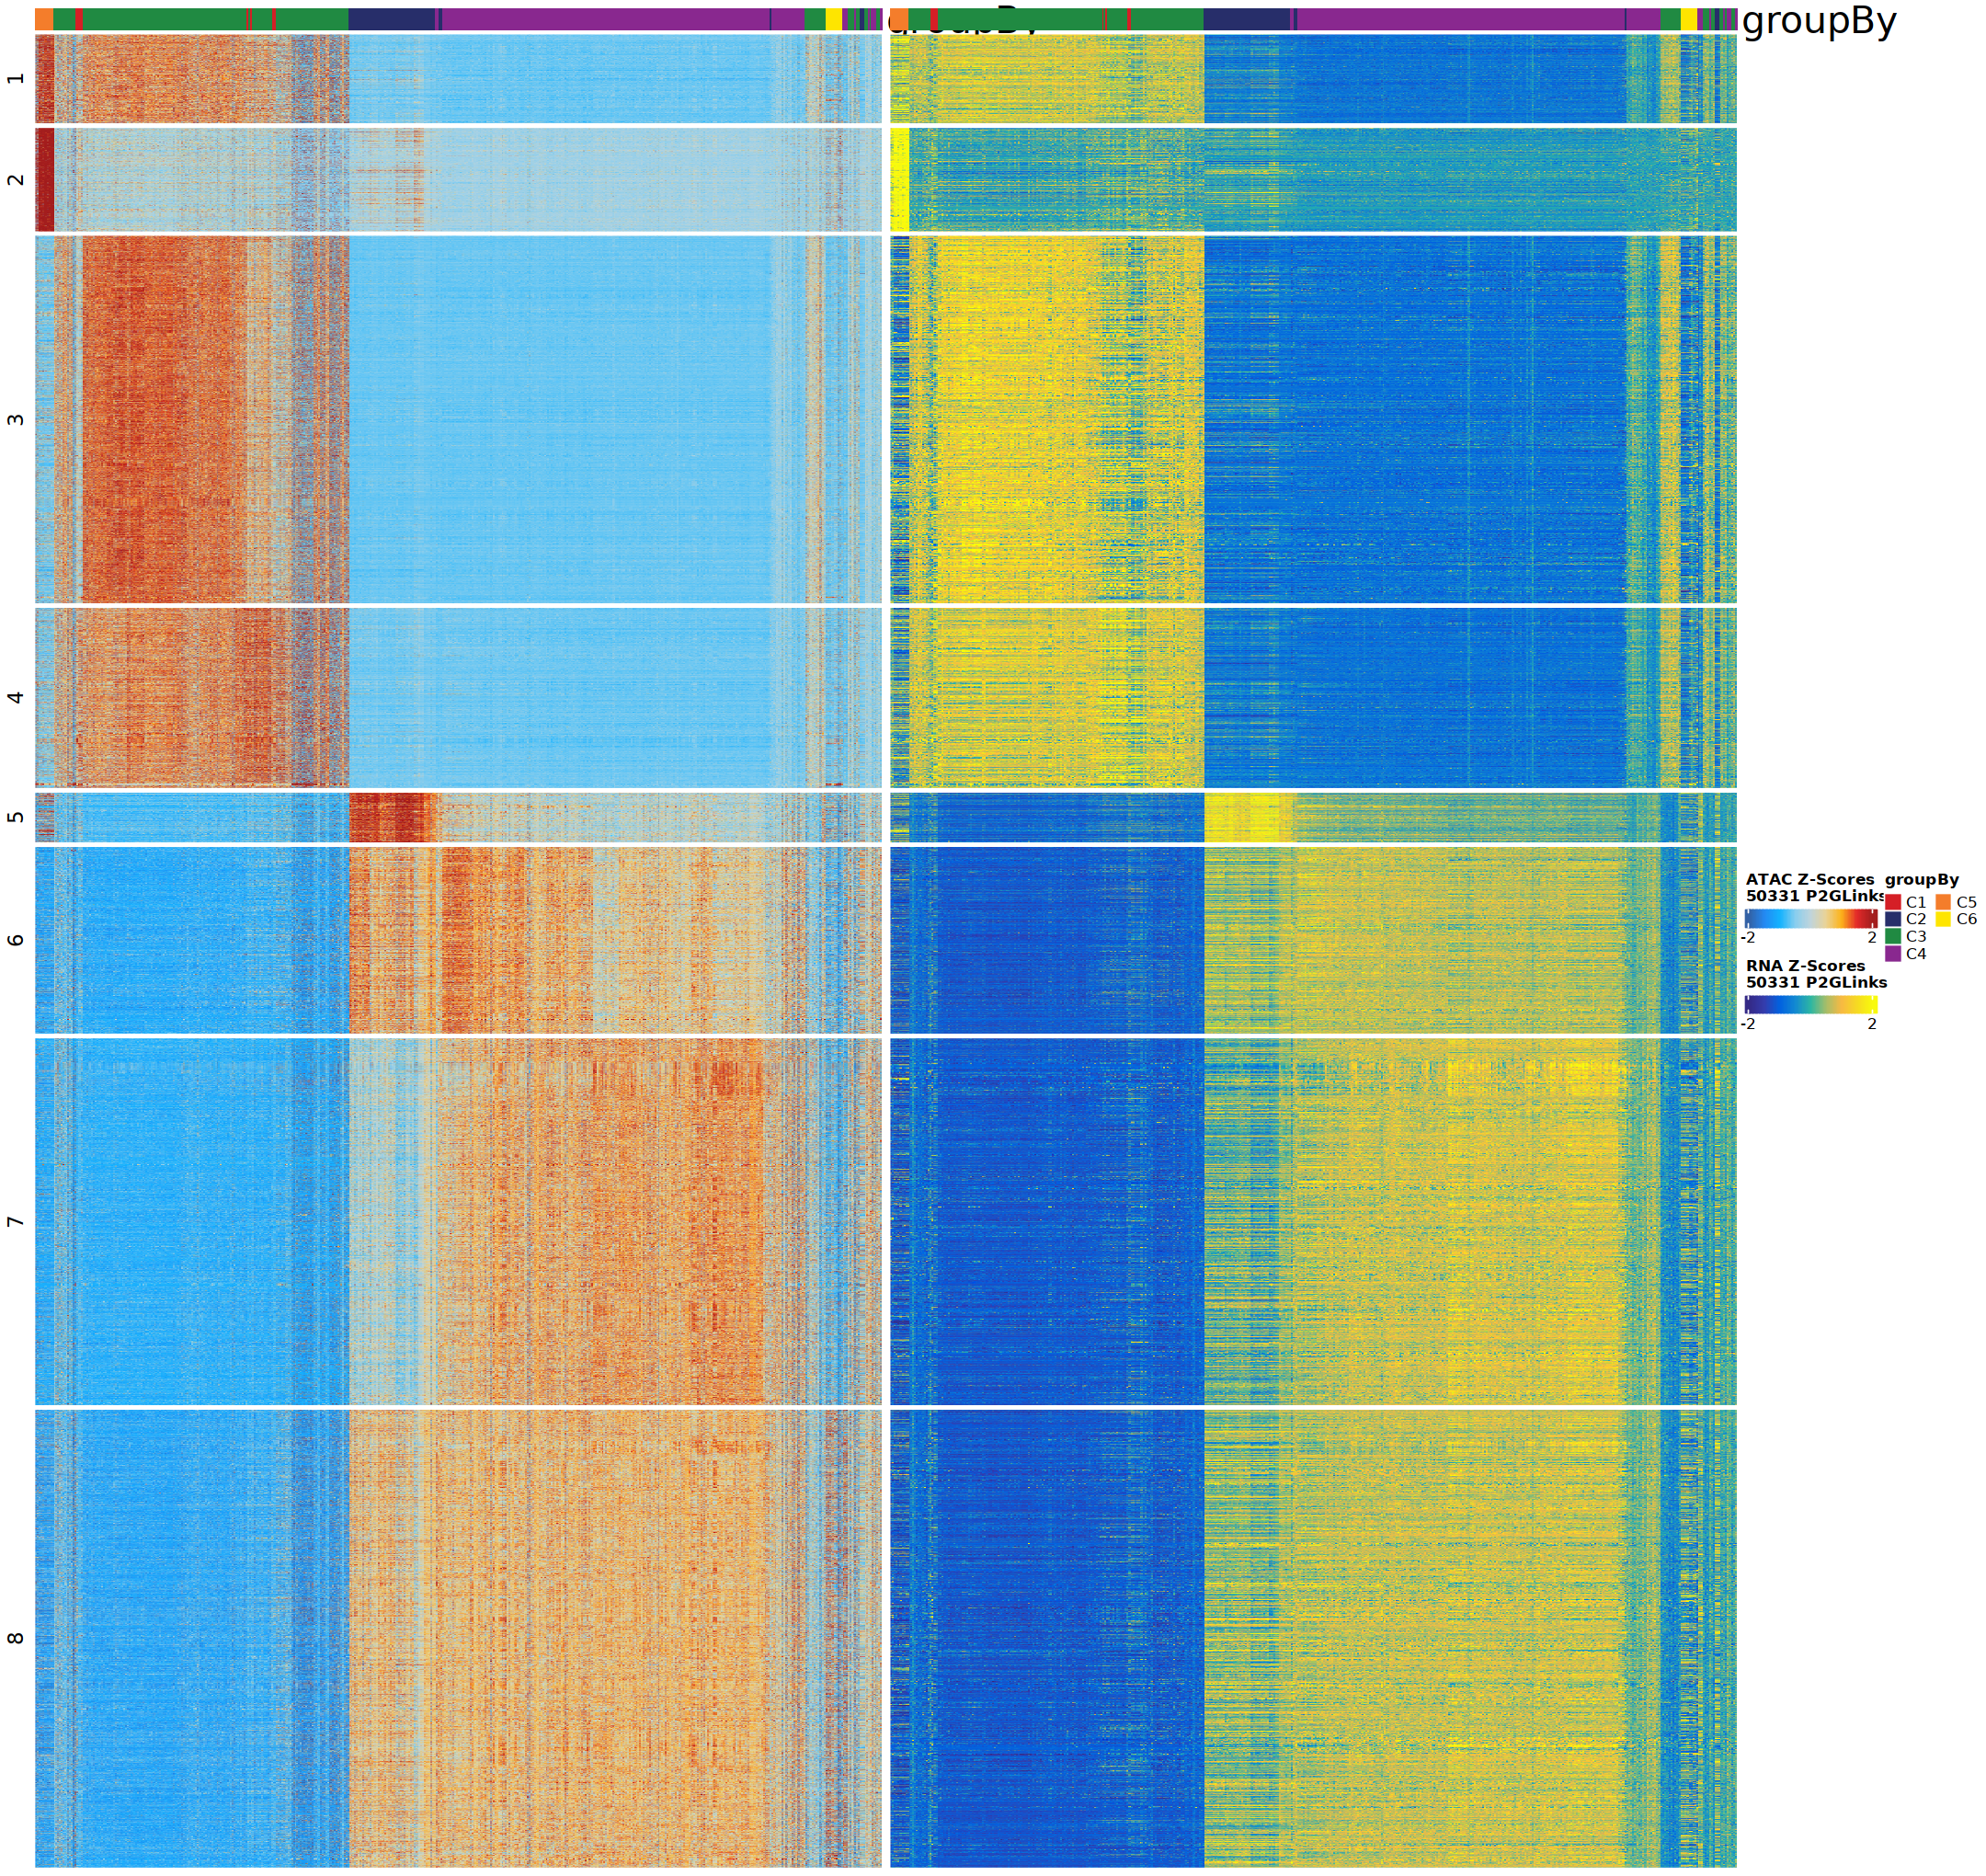

In [12]:
p2gplot

In [13]:
plotDir <- "/home/adufour/work/notebook/plots/omics/P2G"

In [14]:
kclust_df <- data.frame(
  kclust=p2gMat$ATAC$kmeansId,
  peakName=p2gMat$Peak2GeneLinks$peak,
  gene=p2gMat$Peak2GeneLinks$gene
)

In [15]:
kclust_df$peakName <- sapply(kclust_df$peakName, function(x) strsplit(x, ":|-")[[1]] %>% paste(.,collapse="_"))

In [16]:
kclust <- unique(kclust_df$kclust) %>% sort()
all_genes <- kclust_df$gene %>% unique() %>% sort()

In [17]:
# Save table of top linked genes per kclust
nGOgenes <- 1000
topKclustGenes <- lapply(kclust, function(k){
  kclust_df[kclust_df$kclust == k,]$gene %>% getFreqs() %>% head(nGOgenes) %>% names()
  }) %>% do.call(cbind,.)
outfile <- paste0(plotDir, sprintf("/topN_genes_embryo_kclust_k%s.tsv", nclust))
write.table(topKclustGenes, file=outfile, quote=FALSE, sep='\t', row.names = FALSE, col.names=TRUE)

Warning message in cbind(...):
“number of rows of result is not a multiple of vector length (arg 2)”


In [18]:
GOresults <- lapply(kclust, function(k){
  message(sprintf("Running GO enrichments on k cluster %s...", k))
  clust_genes <- topKclustGenes[,k]
  upGO <- rbind(
    calcTopGo(all_genes, interestingGenes=clust_genes, nodeSize=5, ontology="BP") 
    #calcTopGo(all_genes, interestingGenes=clust_genes, nodeSize=5, ontology="MF")
    #calcTopGo(all_genes, interestingGenes=upGenes, nodeSize=5, ontology="CC")
    )
  upGO[order(as.numeric(upGO$pvalue), decreasing=FALSE),]
  })

Running GO enrichments on k cluster 1...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 2...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 3...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 4...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 5...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 6...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 7...

Running GO enrichments with 1000 genes in universe of 8079...

Running GO enrichments on k cluster 8...

Running GO enrichments with 1000 genes in universe of 8079...



In [19]:
names(GOresults) <- paste0("cluster_", kclust)

In [20]:
GOresults

$cluster_1
        GO.ID
1  GO:0050891
2  GO:0030838
3  GO:0022408
4  GO:0007596
5  GO:0033692
6  GO:0031667
7  GO:0031647
8  GO:0006023
9  GO:0010467
10 GO:0045638
11 GO:0006688
12 GO:0071384
13 GO:0038066
14 GO:0032680
15 GO:0009058
16 GO:0048513
17 GO:0007178
18 GO:1903046
19 GO:1902930
20 GO:0006754
21 GO:0046324
22 GO:0051446
23 GO:0006468
24 GO:0032456
25 GO:0042775
26 GO:0019646
27 GO:1901224
28 GO:0140014
29 GO:0007129
30 GO:0060218
31 GO:0046579
32 GO:0006144
33 GO:2000737
34 GO:0007606
35 GO:0120162
36 GO:0031445
37 GO:0001573
38 GO:0043931
39 GO:0071356
40 GO:0033209
41 GO:0046513
42 GO:0060341
43 GO:0051046
44 GO:0030004
45 GO:0098773
46 GO:0006939
47 GO:0048009
48 GO:0006875
49 GO:0009416
50 GO:0048806
                                                                       Term
1                                multicellular organismal water homeostasis
2                      positive regulation of actin filament polymerization
3                                 negative regulation of cell-cell adhesion
4                                                         blood coagulation
5                              cellular polysaccharide biosynthetic process
6                                               response to nutrient levels
7                                           regulation of protein stability
8                                          aminoglycan biosynthetic process
9                                                           gene expression
10                      negative regulation of myeloid cell differentiation
11                                   glycosphingolipid biosynthetic process
12                             cellular response to corticosteroid stimulus
13                                                          p38MAPK cascade
14                           regulation of tumor necrosis factor production
15                                                     biosynthetic process
16                                                 animal organ development
17 transmembrane receptor protein serine/threonine kinase signaling pathway
18                                               meiotic cell cycle process
19                               regulation of alcohol biosynthetic process
20                                                 ATP biosynthetic process
21                                             regulation of glucose import
22                                positive regulation of meiotic cell cycle
23                                                  protein phosphorylation
24                                                      endocytic recycling
25                   mitochondrial ATP synthesis coupled electron transport
26                                         aerobic electron transport chain
27                           positive regulation of NIK/NF-kappaB signaling
28                                                 mitotic nuclear division
29                                 homologous chromosome pairing at meiosis
30                                  hematopoietic stem cell differentiation
31                   positive regulation of Ras protein signal transduction
32                                      purine nucleobase metabolic process
33                         negative regulation of stem cell differentiation
34                                  sensory perception of chemical stimulus
35                        positive regulation of cold-induced thermogenesis
36                                  regulation of heterochromatin formation
37                                            ganglioside metabolic process
38                                 ossification involved in bone maturation
39                               cellular response to tumor necrosis factor
40                         tumor necrosis factor-mediated signaling pathway
41                                            ceramide biosynthetic process
42                                      regulation of cellular localization
43     

In [21]:
library(viridis)

Warning message:
“le package ‘viridis’ a été compilé avec la version R 4.2.3”
Le chargement a nécessité le package : viridisLite

Warning message:
“le package ‘viridisLite’ a été compilé avec la version R 4.2.3”


In [25]:
colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7')

In [26]:
names(colors_dutch) <- c("C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8")

In [29]:
viridis(256, option = "D")

[1] "#440154FF" "#440256FF" "#450457FF" "#450559FF" "#46075AFF" "#46085CFF"
  [7] "#460A5DFF" "#460B5EFF" "#470D60FF" "#470E61FF" "#471063FF" "#471164FF"
 [13] "#471365FF" "#481467FF" "#481668FF" "#481769FF" "#48186AFF" "#481A6CFF"
 [19] "#481B6DFF" "#481C6EFF" "#481D6FFF" "#481F70FF" "#482071FF" "#482173FF"
 [25] "#482374FF" "#482475FF" "#482576FF" "#482677FF" "#482878FF" "#482979FF"
 [31] "#472A7AFF" "#472C7AFF" "#472D7BFF" "#472E7CFF" "#472F7DFF" "#46307EFF"
 [37] "#46327EFF" "#46337FFF" "#463480FF" "#453581FF" "#453781FF" "#453882FF"
 [43] "#443983FF" "#443A83FF" "#443B84FF" "#433D84FF" "#433E85FF" "#423F85FF"
 [49] "#424086FF" "#424186FF" "#414287FF" "#414487FF" "#404588FF" "#404688FF"
 [55] "#3F4788FF" "#3F4889FF" "#3E4989FF" "#3E4A89FF" "#3E4C8AFF" "#3D4D8AFF"
 [61] "#3D4E8AFF" "#3C4F8AFF" "#3C508BFF" "#3B518BFF" "#3B528BFF" "#3A538BFF"
 [67] "#3A548CFF" "#39558CFF" "#39568CFF" "#38588CFF" "#38598CFF" "#375A8CFF"
 [73] "#375B8DFF" "#365C8DFF" "#365D8DFF" "#355E8DFF" "#355F8DFF" "#34608DFF"
 [79] "#34618DFF" "#33628DFF" "#33638DFF" "#32648EFF" "#32658EFF" "#31668EFF"
 [85] "#31678EFF" "#31688EFF" "#30698EFF" "#306A8EFF" "#2F6B8EFF" "#2F6C8EFF"
 [91] "#2E6D8EFF" "#2E6E8EFF" "#2E6F8EFF" "#2D708EFF" "#2D718EFF" "#2C718EFF"
 [97] "#2C728EFF" "#2C738EFF" "#2B748EFF" "#2B758EFF" "#2A768EFF" "#2A778EFF"
[103] "#2A788EFF" "#29798EFF" "#297A8EFF" "#297B8EFF" "#287C8EFF" "#287D8EFF"
[109] "#277E8EFF" "#277F8EFF" "#27808EFF" "#26818EFF" "#26828EFF" "#26828EFF"
[115] "#25838EFF" "#25848EFF" "#25858EFF" "#24868EFF" "#24878EFF" "#23888EFF"
[121] "#23898EFF" "#238A8DFF" "#228B8DFF" "#228C8DFF" "#228D8DFF" "#218E8DFF"
[127] "#218F8DFF" "#21908DFF" "#21918CFF" "#20928CFF" "#20928CFF" "#20938CFF"
[133] "#1F948CFF" "#1F958BFF" "#1F968BFF" "#1F978BFF" "#1F988BFF" "#1F998AFF"
[139] "#1F9A8AFF" "#1E9B8AFF" "#1E9C89FF" "#1E9D89FF" "#1F9E89FF" "#1F9F88FF"
[145] "#1FA088FF" "#1FA188FF" "#1FA187FF" "#1FA287FF" "#20A386FF" "#20A486FF"
[151] "#21A585FF" "#21A685FF" "#22A785FF" "#22A884FF" "#23A983FF" "#24AA83FF"
[157] "#25AB82FF" "#25AC82FF" "#26AD81FF" "#27AD81FF" "#28AE80FF" "#29AF7FFF"
[163] "#2AB07FFF" "#2CB17EFF" "#2DB27DFF" "#2EB37CFF" "#2FB47CFF" "#31B57BFF"
[169] "#32B67AFF" "#34B679FF" "#35B779FF" "#37B878FF" "#38B977FF" "#3ABA76FF"
[175] "#3BBB75FF" "#3DBC74FF" "#3FBC73FF" "#40BD72FF" "#42BE71FF" "#44BF70FF"
[181] "#46C06FFF" "#48C16EFF" "#4AC16DFF" "#4CC26CFF" "#4EC36BFF" "#50C46AFF"
[187] "#52C569FF" "#54C568FF" "#56C667FF" "#58C765FF" "#5AC864FF" "#5CC863FF"
[193] "#5EC962FF" "#60CA60FF" "#63CB5FFF" "#65CB5EFF" "#67CC5CFF" "#69CD5BFF"
[199] "#6CCD5AFF" "#6ECE58FF" "#70CF57FF" "#73D056FF" "#75D054FF" "#77D153FF"
[205] "#7AD151FF" "#7CD250FF" "#7FD34EFF" "#81D34DFF" "#84D44BFF" "#86D549FF"
[211] "#89D548FF" "#8BD646FF" "#8ED645FF" "#90D743FF" "#93D741FF" "#95D840FF"
[217] "#98D83EFF" "#9BD93CFF" "#9DD93BFF" "#A0DA39FF" "#A2DA37FF" "#A5DB36FF"
[223] "#A8DB34FF" "#AADC32FF" "#ADDC30FF" "#B0DD2FFF" "#B2DD2DFF" "#B5DE2BFF"
[229] "#B8DE29FF" "#BADE28FF" "#BDDF26FF" "#C0DF25FF" "#C2DF23FF" "#C5E021FF"
[235] "#C8E020FF" "#CAE11FFF" "#CDE11DFF" "#D0E11CFF" "#D2E21BFF" "#D5E21AFF"
[241] "#D8E219FF" "#DAE319FF" "#DDE318FF" "#DFE318FF" "#E2E418FF" "#E5E419FF"
[247] "#E7E419FF" "#EAE51AFF" "#ECE51BFF" "#EFE51CFF" "#F1E51DFF" "#F4E61EFF"
[253] "#F6E620FF" "#F8E621FF" "#FBE723FF" "#FDE725FF"

In [30]:
# Plots of GO term enrichments:
for(name in names(GOresults)){
    goRes <- GOresults[[name]]
    if(nrow(goRes)>1){
      svglite(paste0("/home/adufour/work/notebook/plots/omics/P2G/p2g_GO_knn", name, "_embryo.svg"), width = 17, height = 20)
      print(topGObarPlot(goRes, cmap = viridis(256, option = "D"), 
        nterms=3, border_color="black", 
        barwidth=0.85, title=name, barLimits=c(0, 15)))
      dev.off()
    }
}

png 
  2

In [52]:
ls()

[1] "all_genes"             "archrproj"             "archrproj_sub"        
 [4] "calcTopGo"             "cellsToKeep"           "chrlist"              
 [7] "data_dir"              "excludeChr"            "geneAnnotation"       
[10] "genomeAnnotation"      "getFreqs"              "goRes"                
[13] "GOresults"             "kclust"                "kclust_df"            
[16] "mat"                   "MotifPositionsInPeaks" "name"                 
[19] "nclust"                "nGOgenes"              "out"                  
[22] "outfile"               "p1"                    "p2"                   
[25] "p2g"                   "p2gMat"                "p2gplot"              
[28] "p3"                    "p4"                    "p4_a"                 
[31] "p4_b"                  "pathToMacs2"           "PFM_list"             
[34] "plotDir"               "pwm_list"              "scRNA"                
[37] "seRNA"                 "seRNA_1"               "seRNA_2"              
[40] "seRNA_3"               "seRNA_4"               "seRNA_5"              
[43] "seRNA_6"               "seRNA_7"               "seRNA_8"              
[46] "seRNA_9"               "seRNAcombined"         "topGObarPlot"         
[49] "topKclustGenes"        "work_dir"

In [23]:
theme_BOR <- function(base_size=14, base_family="Helvetica", border = TRUE) {
  library(grid)
  library(ggthemes)
  # Should plots have a bounding border?
  if(border){
    panel.border <- element_rect(fill = NA, color = "black", size = 0.7)
    axis.line <- element_blank()
  }else{
    panel.border <- element_blank()
    axis.line <- element_line(color = "black", size = 0.5)
  }
  
  (theme_foundation(base_size=base_size, base_family=base_family)
    + theme(plot.title = element_text(size = rel(1.2), hjust = 0.5),
            text = element_text(),
            panel.background = element_rect(colour = NA),
            plot.background = element_rect(colour = NA),
            panel.border = panel.border,
            axis.title = element_text(size = rel(1)),
            axis.title.y = element_text(angle=90,vjust =2),
            axis.title.x = element_text(vjust = -0.2),
            axis.text = element_text(), 
            axis.line = axis.line,
            axis.ticks = element_line(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.key = element_rect(colour = NA),
            legend.position = "right",
            legend.direction = "vertical",
            legend.key.size= unit(0.5, "cm"),
            legend.spacing = unit(0, "cm"),
            legend.title = element_text(),
            plot.margin=unit(c(10,5,5,5),"mm"),
            strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
            strip.text = element_text()
    ))
  
}

In [62]:
table(kclust_df$kclust)


    1     2     3     4     5     6     7     8 
 2490  2888 10260  5037  1402  5223 10244 12787 